In [1]:
# ============================== #
#       1. 匯入必要的套件 + CUDA測試  #
# ============================== #

import os
import re
import numpy as np
import pandas as pd
from datetime import datetime

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from tqdm import tqdm

# 機器學習、模型相關
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

# XGBoost / LightGBM / CatBoost
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# 繪圖相關
import matplotlib.pyplot as plt

# 設定顯示選項
pd.set_option('display.max_columns', None)

# 簡單的 CUDA 測試
print("===================================")
print("        CUDA 測試程式碼開始        ")
print("===================================")
print(f"PyTorch 版本: {torch.__version__}")
print(f"CUDA 可用: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA 驅動版本: {torch.version.cuda}")
    print(f"CUDA CUDNN 版本: {torch.backends.cudnn.version()}")
    print(f"CUDA 設備數量: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"CUDA 設備 {i}: {torch.cuda.get_device_name(i)}")
    print(f"當前使用的 CUDA 設備: {torch.cuda.current_device()}")
else:
    print("CUDA 不可用。請檢查：1. GPU 驅動，2. CUDA Toolkit 版本，3. PyTorch 安裝版本…")

print("===================================")
print("          CUDA 測試程式碼結束       ")
print("===================================")


c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        CUDA 測試程式碼開始        
PyTorch 版本: 2.6.0.dev20241221+cu126
CUDA 可用: True
CUDA 驅動版本: 12.6
CUDA CUDNN 版本: 90501
CUDA 設備數量: 1
CUDA 設備 0: NVIDIA GeForce RTX 3050 Laptop GPU
當前使用的 CUDA 設備: 0
          CUDA 測試程式碼結束       


In [5]:
# ============================== #
# 2. 定義新聞資料處理與清理 + 輔助函數 #
# ============================== #

def clean_text(txt: str) -> str:
    """簡單文本清理，去除多餘空白和雜訊。"""
    if not isinstance(txt, str):
        return ""
    txt = re.sub(r'\s+', ' ', txt)
    return txt.strip()

def parse_cnbc_time(t):
    """解析 CNBC 的時間格式: '7:51 PM ET Fri, 17 July 2020'"""
    if not isinstance(t, str):
        return None
    try:
        dt = datetime.strptime(t, '%I:%M %p ET %a, %d %B %Y')
        return dt.strftime('%Y-%m-%d')
    except:
        return None

def parse_guardian_time(t):
    """解析 Guardian 的時間格式: '18-Jul-20'"""
    if not isinstance(t, str):
        return None
    try:
        dt = datetime.strptime(t.strip(), '%d-%b-%y')
        return dt.strftime('%Y-%m-%d')
    except:
        return None

def parse_reuters_time(t):
    """解析 Reuters 的時間格式: 'Jul 18 2020'"""
    if not isinstance(t, str):
        return None
    try:
        dt = datetime.strptime(t.strip(), '%b %d %Y')
        return dt.strftime('%Y-%m-%d')
    except:
        return None

def load_cnbc(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, on_bad_lines='skip', engine='python')
    expected_cols = ['Headlines', 'Time', 'Description']
    for col in expected_cols:
        if col not in df.columns:
            print(f"警告: CNBC CSV 缺少欄位 '{col}'")
    df['headline'] = df['Headlines'].fillna("").apply(clean_text)
    df['article_content'] = df['Description'].fillna("").apply(clean_text)
    df['date'] = df['Time'].apply(parse_cnbc_time)
    df = df[['date', 'headline', 'article_content']].dropna(subset=['date', 'headline'])
    df['source'] = 'CNBC'
    return df

def load_guardian(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, on_bad_lines='skip', engine='python')
    expected_cols = ['Time', 'Headlines']
    for col in expected_cols:
        if col not in df.columns:
            print(f"警告: Guardian CSV 缺少欄位 '{col}'")
    df['headline'] = df['Headlines'].fillna("").apply(clean_text)
    df['article_content'] = ""  # Guardian 無 Description
    df['date'] = df['Time'].apply(parse_guardian_time)
    df = df[['date', 'headline', 'article_content']].dropna(subset=['date', 'headline'])
    df['source'] = 'Guardian'
    return df

def load_reuters(csv_path: str) -> pd.DataFrame:
    # 如果報 ParserError，請視情況調整 on_bad_lines='skip'、sep=',' 等
    df = pd.read_csv(csv_path, on_bad_lines='skip', engine='python')
    expected_cols = ['Headlines', 'Time', 'Description']
    for col in expected_cols:
        if col not in df.columns:
            print(f"警告: Reuters CSV 缺少欄位 '{col}'")
    df['headline'] = df['Headlines'].fillna("").apply(clean_text)
    df['article_content'] = df['Description'].fillna("").apply(clean_text)
    df['date'] = df['Time'].apply(parse_reuters_time)
    df = df[['date', 'headline', 'article_content']].dropna(subset=['date', 'headline'])
    df['source'] = 'Reuters'
    return df

def merge_news(cnbc_csv, guardian_csv, reuters_csv):
    """
    讀取並合併 CNBC、Guardian 和 Reuters 的新聞資料。
    """
    cnbc_df = load_cnbc(cnbc_csv)
    guardian_df = load_guardian(guardian_csv)
    reuters_df = load_reuters(reuters_csv)

    df_news = pd.concat([cnbc_df, guardian_df, reuters_df], ignore_index=True)
    df_news['date'] = pd.to_datetime(df_news['date'])

    df_news.sort_values('date', inplace=True)
    df_news.reset_index(drop=True, inplace=True)
    return df_news

def setup_finbert_pipeline():
    """初始化 FinBERT pipeline"""
    tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
    model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
    device = 0 if torch.cuda.is_available() else -1
    finbert_pipeline = pipeline(
        "sentiment-analysis",
        model=model,
        tokenizer=tokenizer,
        device=device
    )
    print(f"FinBERT pipeline 使用的設備: {'GPU (0)' if device == 0 else 'CPU'}")
    return finbert_pipeline

def batch_sentiment(text_list, pipeline_fn, batch_size=16, max_length=128):
    """
    手動分批，並使用 tqdm 進度條顯示處理進度。
    """
    results = []
    for i in tqdm(range(0, len(text_list), batch_size), desc="Sentiment Analysis Batches"):
        batch_texts = text_list[i:i+batch_size]
        try:
            batch_out = pipeline_fn(
                batch_texts,
                truncation=True,
                max_length=max_length
            )
            for out in batch_out:
                label = out['label'].lower()
                score = out['score']
                if label == 'positive':
                    results.append(+score)
                elif label == 'negative':
                    results.append(-score)
                else:
                    results.append(0.0)
        except Exception as e:
            print(f"批次 {i//batch_size + 1} 解析錯誤: {e}")
            results.extend([0.0]*len(batch_texts))
    return results

def compute_daily_sentiment(df_news: pd.DataFrame, sentiment_pipeline, batch_size=16, max_length=128) -> pd.DataFrame:
    """
    對 headline & article_content 做批次情緒分析，並彙整成每日平均分數。
    """
    print("開始批次情緒分析 (FinBERT) ...")

    # headline
    headlines = df_news['headline'].tolist()
    print("-> 分析 Headline")
    headline_scores = batch_sentiment(headlines, sentiment_pipeline, batch_size=batch_size, max_length=max_length)

    # content
    contents = df_news['article_content'].tolist()
    print("-> 分析 Content")
    content_scores = batch_sentiment(contents, sentiment_pipeline, batch_size=batch_size, max_length=max_length)

    df_news['headline_sent'] = headline_scores
    df_news['content_sent']  = content_scores

    print("-> 彙整當日情緒...")
    daily_sentiment = (
        df_news
        .groupby('date')
        .agg({'headline_sent':'mean','content_sent':'mean'})
        .reset_index()
        .rename(columns={
            'headline_sent': 'mean_headline_sent',
            'content_sent': 'mean_content_sent'
        })
    )
    print("情緒分析完成。若出現負值，代表負面新聞居多。")
    return daily_sentiment

def load_sp500(sp_csv_path: str) -> pd.DataFrame:
    df_sp = pd.read_csv(sp_csv_path, on_bad_lines='skip', engine='python')
    df_sp.rename(columns={'Date':'date','S&P500':'sp_close'}, inplace=True)
    # 把下面這行的 .dt.strftime('%Y-%m-%d') 拿掉
    df_sp['date'] = pd.to_datetime(df_sp['date'])
    df_sp.sort_values('date', inplace=True)
    return df_sp


def create_labels_for_prediction(df: pd.DataFrame, mode='classification'):
    """
    mode='classification': 隔日漲(1)/跌(0)
    mode='regression': 預測隔日收盤價
    """
    df['sp_close_next'] = df['sp_close'].shift(-1)
    df = df.dropna(subset=['sp_close_next'])
    if mode == 'classification':
        df['target'] = (df['sp_close_next'] > df['sp_close']).astype(int)
    else:
        df['target'] = df['sp_close_next']
    return df

def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    # 移動平均線
    df['MA_5'] = df['sp_close'].rolling(window=5).mean()
    df['MA_10'] = df['sp_close'].rolling(window=10).mean()

    # RSI
    delta = df['sp_close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    RS = gain / loss
    df['RSI'] = 100 - (100 / (1 + RS))

    # MACD
    ema_12 = df['sp_close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['sp_close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_diff'] = df['MACD'] - df['MACD_signal']

    # Bollinger Bands
    df['BB_upper'] = df['MA_10'] + 2 * df['sp_close'].rolling(window=10).std()
    df['BB_lower'] = df['MA_10'] - 2 * df['sp_close'].rolling(window=10).std()

    df.dropna(inplace=True)
    return df

def add_sentiment_features(df: pd.DataFrame, sentiment_col='mean_headline_sent', lags=[1,2,3]) -> pd.DataFrame:
    # 情緒變動值
    df['sentiment_change_1'] = df[sentiment_col].diff(1)
    df['sentiment_change_2'] = df[sentiment_col].diff(2)
    df['sentiment_change_3'] = df[sentiment_col].diff(3)
    # 滯後情緒
    for lag in lags:
        df[f'sentiment_lag_{lag}'] = df[sentiment_col].shift(lag)

    df.dropna(inplace=True)
    return df

def add_sp500_features(df: pd.DataFrame, lags=[1,2,3], rolling_window=5) -> pd.DataFrame:
    df['sp_return'] = df['sp_close'].pct_change()
    for lag in lags:
        df[f'sp_return_lag_{lag}'] = df['sp_return'].shift(lag)
    df[f'sp_return_mean_{rolling_window}'] = df['sp_return'].rolling(window=rolling_window).mean()

    for lag in lags:
        df[f'sp_close_lag_{lag}'] = df['sp_close'].shift(lag)

    df.dropna(inplace=True)
    return df

def add_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df = add_technical_indicators(df)
    df = add_sentiment_features(df, sentiment_col='mean_headline_sent', lags=[1,2,3])
    df = add_sp500_features(df, lags=[1,2,3], rolling_window=5)

    if 'date' not in df.columns:
        raise KeyError("'date' 欄位在特徵工程後遺失。")
    return df


In [3]:
# ============================== #
# 3. 定義模型訓練函數 & 交叉驗證      #
# ============================== #

def train_random_forest(X_train, y_train):
    """訓練 Random Forest 模型。"""
    clf = RandomForestClassifier(
        n_estimators=150,
        random_state=42,
        class_weight="balanced"
    )
    clf.fit(X_train, y_train)
    return clf

def train_xgboost(X_train, y_train):
    """訓練 XGBoost 模型，使用 GPU（若可用）。"""
    clf = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=150,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1,
        tree_method='gpu_hist' if torch.cuda.is_available() else 'auto',
        predictor='gpu_predictor' if torch.cuda.is_available() else 'cpu_predictor',
        gpu_id=0,
        random_state=42
    )
    clf.fit(X_train, y_train)
    return clf

def train_lightgbm(X_train, y_train):
    """訓練 LightGBM 模型，使用 GPU。"""
    device_type = 'gpu' if torch.cuda.is_available() else 'cpu'
    clf = lgb.LGBMClassifier(
        boosting_type='gbdt',
        device=device_type,
        n_estimators=150,
        learning_rate=0.1,
        max_depth=10,
        num_leaves=31,
        min_data_in_leaf=10,
        class_weight='balanced',
        random_state=42
    )
    clf.fit(X_train, y_train)
    return clf

def train_catboost(X_train, y_train):
    """訓練 CatBoost 模型，使用 GPU。"""
    task_type = 'GPU' if torch.cuda.is_available() else 'CPU'
    clf = cb.CatBoostClassifier(
        iterations=150,
        learning_rate=0.1,
        depth=5,
        class_weights=[2,1],  # 簡易平衡
        task_type=task_type,
        devices='0',
        verbose=0,
        random_state=42
    )
    clf.fit(X_train, y_train)
    return clf

def train_mlp(X_train, y_train):
    """訓練 MLP 模型 (sklearn 版本)。"""
    clf = MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42
    )
    clf.fit(X_train, y_train)
    return clf

# 注意：Stacking需要的estimator必須都是分類器物件，而非函式
def get_stacking_model():
    """
    建立 Stacking 模型，結合數個已知的分類器 (這裡直接放物件)。
    由於 sklearn 的 VotingClassifier / StackingClassifier 需要傳入 (name, estimator)。
    """
    # 這裡使用簡易 VotingClassifier 當作 Stacking 的示範
    est_rf = RandomForestClassifier(n_estimators=150, random_state=42, class_weight='balanced')
    est_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    est_lgbm = lgb.LGBMClassifier(random_state=42)
    est_cb = cb.CatBoostClassifier(iterations=100, verbose=0, random_state=42)

    stacking_clf = VotingClassifier(
        estimators=[
            ('rf', est_rf),
            ('xgb', est_xgb),
            ('lgb', est_lgbm),
            ('cat', est_cb)
        ],
        voting='soft'
    )
    return stacking_clf

def train_stacking(X_train, y_train):
    """訓練 Stacking (這裡實際是 VotingClassifier) 模型。"""
    stacking_clf = get_stacking_model()
    stacking_clf.fit(X_train, y_train)
    return stacking_clf

# 交叉驗證
def evaluate_classification(y_true, y_pred, y_prob=None):
    """評估分類模型。"""
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob) if y_prob is not None else None

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if auc is not None:
        print(f"AUC-ROC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    return acc, f1, auc

def timeseries_cv_and_train(X, y, model_fn, n_splits=5):
    """
    使用 TimeSeriesSplit 進行交叉驗證，回傳平均 Accuracy、F1 分數和 AUC-ROC。
    model_fn: 傳入可呼叫 (X_train, y_train) -> (model)
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    acc_scores = []
    f1_scores = []
    auc_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f"\nFold {fold_idx+1}/{n_splits} 開始...")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train_, y_val = y[train_idx], y[val_idx]

        print(f"Fold {fold_idx+1} - X_train shape: {X_train.shape}")
        print(f"Fold {fold_idx+1} - X_val shape: {X_val.shape}")
        print(f"Fold {fold_idx+1} - y_train shape: {y_train_.shape}")
        print(f"Fold {fold_idx+1} - y_val shape: {y_val.shape}")

        model = model_fn(X_train, y_train_)
        y_pred = model.predict(X_val)

        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_val)[:,1]
        else:
            y_prob = None

        acc, f1, auc = evaluate_classification(y_val, y_pred, y_prob)
        acc_scores.append(acc)
        f1_scores.append(f1)
        auc_scores.append(auc if auc is not None else 0.0)

    avg_acc = np.mean(acc_scores)
    avg_f1 = np.mean(f1_scores)
    avg_auc = np.mean(auc_scores)
    print(f"\n=== TimeSeriesSplit 平均 ACC: {avg_acc:.4f}, F1: {avg_f1:.4f}, AUC-ROC: {avg_auc:.4f} ===")
    return avg_acc, avg_f1, avg_auc

# ======== XGBoost超參數調整範例 ======== #
def train_xgboost_gridsearch(X_train, y_train):
    """
    使用 GridSearchCV 進行超參數調整的 XGBoost。
    """
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'scale_pos_weight': [1, 2, 3]
    }

    clf = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42
    )

    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=param_grid,
        scoring='accuracy',
        cv=3,
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

    best_model = grid_search.best_estimator_
    return best_model

def train_xgboost_randomsearch(X_train, y_train):
    """
    使用 RandomizedSearchCV 進行超參數調整的 XGBoost。
    """
    param_dist = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 10],
        'subsample': [0.6, 0.7, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2, 0.3],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [1, 1.5, 2]
    }

    clf = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42
    )

    random_search = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_dist,
        n_iter=50,          # 可自行調大
        scoring='accuracy',
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(X_train, y_train)
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best cross-validation accuracy: {random_search.best_score_:.4f}")

    best_model = random_search.best_estimator_
    return best_model


In [4]:
# ============================== #
# 4. 主流程 (讀取資料, 進行訓練, 評估, 視覺化) #
# ============================== #

# ============ 4.1 讀取新聞資料 & 進行情緒分析 ============
# 範例 CSV 路徑 (請自行修正)
cnbc_csv     = "test/cnbc_headlines.csv"
guardian_csv = "test/guardian_headlines.csv"
reuters_csv  = "test/reuters_headlines.csv"

df_news = merge_news(cnbc_csv, guardian_csv, reuters_csv)
print(f"[News] total: {len(df_news)} rows from 3 sources.")

# 初始化 FinBERT
finbert_pipe = setup_finbert_pipeline()

# 執行情緒分析
daily_sentiment_df = compute_daily_sentiment(df_news, finbert_pipe,
                                                batch_size=32, max_length=128)
daily_sentiment_df.to_csv("daily_sentiment.csv", index=False)
print("[Output] daily_sentiment.csv 已輸出.")



[News] total: 50638 rows from 3 sources.


Device set to use cuda:0


FinBERT pipeline 使用的設備: GPU (0)
開始批次情緒分析 (FinBERT) ...
-> 分析 Headline


Sentiment Analysis Batches: 100%|██████████| 1583/1583 [08:31<00:00,  3.10it/s]


-> 分析 Content


Sentiment Analysis Batches: 100%|██████████| 1583/1583 [10:33<00:00,  2.50it/s]


-> 彙整當日情緒...
情緒分析完成。若出現負值，代表負面新聞居多。
[Output] daily_sentiment.csv 已輸出.
[SP500] total: 2516 rows.


ValueError: You are trying to merge on datetime64[ns] and object columns for key 'date'. If you wish to proceed you should use pd.concat

In [6]:
# ============ 4.2 讀取 S&P500 資料 ============
sp500_csv    = "test/sp500_index.csv"
df_sp = load_sp500(sp500_csv)
print(f"[SP500] total: {len(df_sp)} rows.")

# ============ 4.3 合併情緒 & 股市資料 + 建標籤 ============
df_merged = pd.merge(daily_sentiment_df, df_sp, on='date', how='inner')
df_merged.sort_values('date', inplace=True)
df_merged.dropna(inplace=True)
df_merged = create_labels_for_prediction(df_merged, mode='classification')

# ============ 4.4 添加所有特徵 ============
df_merged = add_feature_engineering(df_merged)
print(f"[Merged Data] shape={df_merged.shape}")

# 特徵列表
features = [
    'mean_headline_sent','mean_content_sent','sp_close',
    'sp_close_lag_1','sp_close_lag_2','sp_close_lag_3',
    'MA_5','MA_10','RSI','MACD','MACD_signal','MACD_diff',
    'BB_upper','BB_lower','sentiment_change_1','sentiment_change_2','sentiment_change_3',
    'sentiment_lag_1','sentiment_lag_2','sentiment_lag_3',
    'sp_return','sp_return_lag_1','sp_return_lag_2','sp_return_lag_3','sp_return_mean_5'
]
df_merged[features] = df_merged[features].astype(float).fillna(0)

X_full = df_merged[features].values
y_full = df_merged['target'].values

# 標準化
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)

[SP500] total: 2516 rows.
[Merged Data] shape=(622, 28)


C:\Users\morri\AppData\Local\Temp\ipykernel_9956\2968158264.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = (df['sp_close_next'] > df['sp_close']).astype(int)


In [7]:
# ============ 4.5 交叉驗證測試幾種模型 ============
print("\n=== TimeSeriesSplit: Random Forest ===")
def model_fn_rf(X, y):
    model = train_random_forest(X, y)
    return model
avg_acc_rf, avg_f1_rf, avg_auc_rf = timeseries_cv_and_train(
    X_full_scaled, y_full, model_fn=model_fn_rf, n_splits=3
)

print("\n=== TimeSeriesSplit: XGBoost ===")
def model_fn_xgb(X, y):
    model = train_xgboost(X, y)
    return model
avg_acc_xgb, avg_f1_xgb, avg_auc_xgb = timeseries_cv_and_train(
    X_full_scaled, y_full, model_fn=model_fn_xgb, n_splits=3
)

print("\n=== TimeSeriesSplit: LightGBM ===")
def model_fn_lgbm(X, y):
    model = train_lightgbm(X, y)
    return model
avg_acc_lgbm, avg_f1_lgbm, avg_auc_lgbm = timeseries_cv_and_train(
    X_full_scaled, y_full, model_fn=model_fn_lgbm, n_splits=3
)

print("\n=== TimeSeriesSplit: CatBoost ===")
def model_fn_cat(X, y):
    model = train_catboost(X, y)
    return model
avg_acc_cb, avg_f1_cb, avg_auc_cb = timeseries_cv_and_train(
    X_full_scaled, y_full, model_fn=model_fn_cat, n_splits=3
)

print("\n=== TimeSeriesSplit: MLP ===")
def model_fn_mlp_(X, y):
    model = train_mlp(X, y)
    return model
avg_acc_mlp, avg_f1_mlp, avg_auc_mlp = timeseries_cv_and_train(
    X_full_scaled, y_full, model_fn=model_fn_mlp_, n_splits=3
)

print("\n=== TimeSeriesSplit: Stacking ===")
def model_fn_stack(X, y):
    model = train_stacking(X, y)
    return model
avg_acc_stack, avg_f1_stack, avg_auc_stack = timeseries_cv_and_train(
    X_full_scaled, y_full, model_fn=model_fn_stack, n_splits=3
)

print("\n=== TimeSeriesSplit: XGBoost GridSearch ===")
def model_fn_xgb_grid(X, y):
    model = train_xgboost_gridsearch(X, y)
    return model
avg_acc_xgb_grid, avg_f1_xgb_grid, avg_auc_xgb_grid = timeseries_cv_and_train(
    X_full_scaled, y_full, model_fn=model_fn_xgb_grid, n_splits=3
)

print("\n=== TimeSeriesSplit: XGBoost RandomSearch ===")
def model_fn_xgb_rand(X, y):
    model = train_xgboost_randomsearch(X, y)
    return model
avg_acc_xgb_random, avg_f1_xgb_random, avg_auc_xgb_random = timeseries_cv_and_train(
    X_full_scaled, y_full, model_fn=model_fn_xgb_rand, n_splits=3
)

# 挑選測試 ACC 最好的
model_acc = {
    "RandomForest": avg_acc_rf,
    "XGBoost": avg_acc_xgb,
    "LightGBM": avg_acc_lgbm,
    "CatBoost": avg_acc_cb,
    "MLP": avg_acc_mlp,
    "Stacking": avg_acc_stack,
    "XGBoost_GridSearch": avg_acc_xgb_grid,
    "XGBoost_RandomSearch": avg_acc_xgb_random
}
best_model_name = max(model_acc, key=model_acc.get)
best_acc = model_acc[best_model_name]
print(f"\n[Best Model] {best_model_name}, ACC={best_acc:.4f}")


=== TimeSeriesSplit: Random Forest ===

Fold 1/3 開始...
Fold 1 - X_train shape: (157, 25)
Fold 1 - X_val shape: (155, 25)
Fold 1 - y_train shape: (157,)
Fold 1 - y_val shape: (155,)
Accuracy: 0.5419
F1 Score: 0.6120
AUC-ROC: 0.5188

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.38      0.44        73
           1       0.55      0.68      0.61        82

    accuracy                           0.54       155
   macro avg       0.54      0.53      0.53       155
weighted avg       0.54      0.54      0.53       155


Fold 2/3 開始...
Fold 2 - X_train shape: (312, 25)
Fold 2 - X_val shape: (155, 25)
Fold 2 - y_train shape: (312,)
Fold 2 - y_val shape: (155,)
Accuracy: 0.4387
F1 Score: 0.1031
AUC-ROC: 0.4844

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.93      0.59        68
           1       0.50      0.06      0.10        87

    accuracy                         

c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:37:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:37:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:37:43] WARNING: C:\buildki

Accuracy: 0.5161
F1 Score: 0.5810
AUC-ROC: 0.5015

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.38      0.43        73
           1       0.54      0.63      0.58        82

    accuracy                           0.52       155
   macro avg       0.51      0.51      0.50       155
weighted avg       0.51      0.52      0.51       155


Fold 2/3 開始...
Fold 2 - X_train shape: (312, 25)
Fold 2 - X_val shape: (155, 25)
Fold 2 - y_train shape: (312,)
Fold 2 - y_val shape: (155,)


c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:37:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:37:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\morri\AppData\Local\Programs\Python\Python311

Accuracy: 0.4452
F1 Score: 0.1887
AUC-ROC: 0.5078

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.87      0.58        68
           1       0.53      0.11      0.19        87

    accuracy                           0.45       155
   macro avg       0.48      0.49      0.38       155
weighted avg       0.49      0.45      0.36       155


Fold 3/3 開始...
Fold 3 - X_train shape: (467, 25)
Fold 3 - X_val shape: (155, 25)
Fold 3 - y_train shape: (467,)
Fold 3 - y_val shape: (155,)


c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:37:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy: 0.5484
F1 Score: 0.5977
AUC-ROC: 0.5316

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.51      0.49        65
           1       0.62      0.58      0.60        90

    accuracy                           0.55       155
   macro avg       0.54      0.54      0.54       155
weighted avg       0.55      0.55      0.55       155


=== TimeSeriesSplit 平均 ACC: 0.5032, F1: 0.4558, AUC-ROC: 0.5136 ===

=== TimeSeriesSplit: LightGBM ===

Fold 1/3 開始...
Fold 1 - X_train shape: (157, 25)
Fold 1 - X_val shape: (155, 25)
Fold 1 - y_train shape: (157,)
Fold 1 - y_val shape: (155,)
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 86, number of negative: 71
[LightGBM] [Info] This is the GPU trainer!!


Accuracy: 0.4645
F1 Score: 0.4908
AUC-ROC: 0.4875

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.44      0.44        73
           1       0.49      0.49      0.49        82

    accuracy                           0.46       155
   macro avg       0.46      0.46      0.46       155
weighted avg       0.46      0.46      0.46       155


Fold 2/3 開始...
Fold 2 - X_train shape: (312, 25)
Fold 2 - X_val shape: (155, 25)
Fold 2 - y_train shape: (312,)
Fold 2 - y_val shape: (155,)


Accuracy: 0.4323
F1 Score: 0.1538
AUC-ROC: 0.4420

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.87      0.57        68
           1       0.47      0.09      0.15        87

    accuracy                           0.43       155
   macro avg       0.45      0.48      0.36       155
weighted avg       0.45      0.43      0.34       155


Fold 3/3 開始...
Fold 3 - X_train shape: (467, 25)
Fold 3 - X_val shape: (155, 25)
Fold 3 - y_train shape: (467,)
Fold 3 - y_val shape: (155,)


Accuracy: 0.4710
F1 Score: 0.5233
AUC-ROC: 0.4797

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.43      0.41        65
           1       0.55      0.50      0.52        90

    accuracy                           0.47       155
   macro avg       0.47      0.47      0.46       155
weighted avg       0.48      0.47      0.47       155


=== TimeSeriesSplit 平均 ACC: 0.4559, F1: 0.3893, AUC-ROC: 0.4697 ===

=== TimeSeriesSplit: MLP ===

Fold 1/3 開始...
Fold 1 - X_train shape: (157, 25)
Fold 1 - X_val shape: (155, 25)
Fold 1 - y_train shape: (157,)
Fold 1 - y_val shape: (155,)
Accuracy: 0.5484
F1 Score: 0.5783
AUC-ROC: 0.5638

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.51      0.51        73
           1       0.57      0.59      0.58        82

    accuracy                           0.55       155
   macro avg       0.55      0.55      0.55       155
weighted avg

c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:38:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 86, number of negative: 71
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1341
[LightGBM] [Info] Number of data points in the train set: 157, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547771 -> initscore=0.191667
[LightGBM] [Info] Start training from score 0.191667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:38:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 168, number of negative: 144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 312, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538462 -> initscore=0.154151
[LightGBM] [Info] Start training from score 0.154151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:38:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 255, number of negative: 212
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3901
[LightGBM] [Info] Number of data points in the train set: 467, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546039 -> initscore=0.184677
[LightGBM] [Info] Start training from score 0.184677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [8]:
# ============ 4.6 用最優模型做最終訓練、測試 ============

# 以 80% 當作訓練集
split_ratio = 0.8
split_index = int(len(df_merged) * split_ratio)

df_train = df_merged.iloc[:split_index].copy()
df_test = df_merged.iloc[split_index:].copy()

X_train_full = X_full_scaled[:split_index]
y_train_full = y_full[:split_index]
X_test_full  = X_full_scaled[split_index:]
y_test_full  = y_full[split_index:]

# SMOTE 處理類別不平衡
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_full, y_train_full)

# 根據 best_model_name 取得最終模型
def get_best_model(model_name):
    if model_name == "RandomForest":
        return train_random_forest(X_train_resampled, y_train_resampled)
    elif model_name == "XGBoost":
        return train_xgboost(X_train_resampled, y_train_resampled)
    elif model_name == "LightGBM":
        return train_lightgbm(X_train_resampled, y_train_resampled)
    elif model_name == "CatBoost":
        return train_catboost(X_train_resampled, y_train_resampled)
    elif model_name == "MLP":
        return train_mlp(X_train_resampled, y_train_resampled)
    elif model_name == "Stacking":
        return train_stacking(X_train_resampled, y_train_resampled)
    elif model_name == "XGBoost_GridSearch":
        return train_xgboost_gridsearch(X_train_resampled, y_train_resampled)
    elif model_name == "XGBoost_RandomSearch":
        return train_xgboost_randomsearch(X_train_resampled, y_train_resampled)
    else:
        raise ValueError("未知的模型名稱")

final_model = get_best_model(best_model_name)

# 預測
y_pred_test = final_model.predict(X_test_full)
y_prob_test = None
if hasattr(final_model, "predict_proba"):
    y_prob_test = final_model.predict_proba(X_test_full)[:,1]

def evaluate_final_model(y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob) if y_prob is not None else None

    print(f"Final Model Accuracy: {acc:.4f}")
    print(f"Final Model F1 Score: {f1:.4f}")
    if auc is not None:
        print(f"Final Model AUC-ROC: {auc:.4f}")

    print("\nFinal Model Classification Report:")
    print(classification_report(y_true, y_pred))

    return acc, f1, auc

acc_test, f1_test, auc_test = evaluate_final_model(y_test_full, y_pred_test, y_prob_test)

# 將最終預測結果加入 df_test
df_test['y_pred'] = y_pred_test

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 3, 'subsample': 0.7}
Best cross-validation accuracy: 0.5453
Final Model Accuracy: 0.5200
Final Model F1 Score: 0.6512
Final Model AUC-ROC: 0.4586

Final Model Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.16      0.23        56
           1       0.54      0.81      0.65        69

    accuracy                           0.52       125
   macro avg       0.48      0.49      0.44       125
weighted avg       0.48      0.52      0.46       125



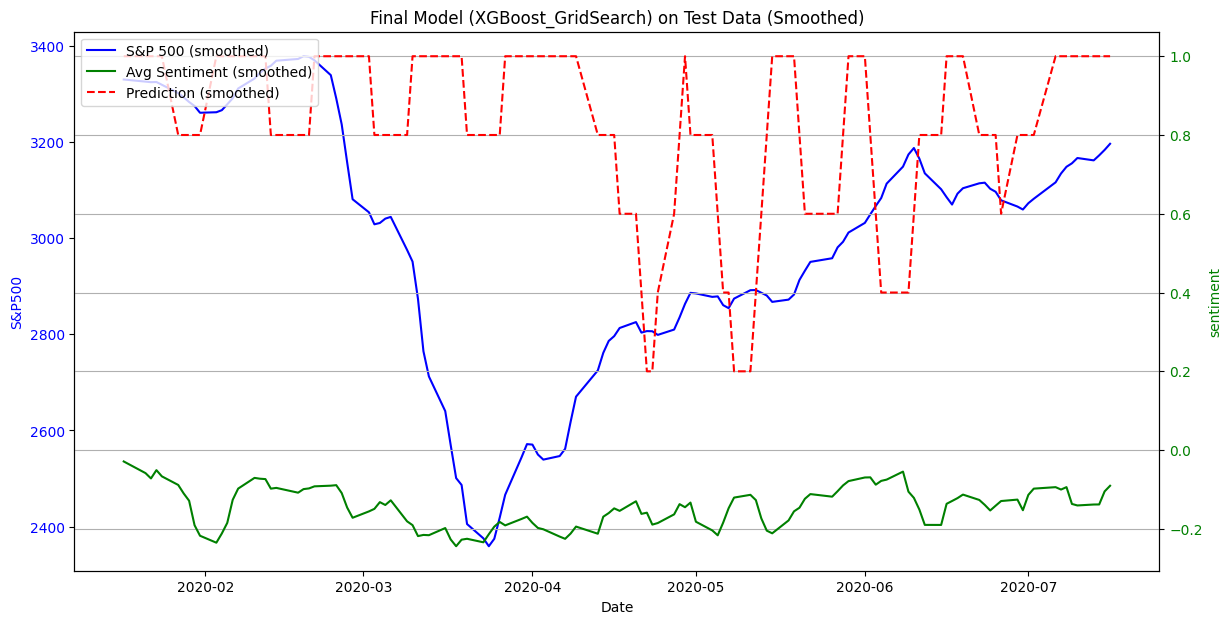

merged_data.csv 已輸出.


In [9]:
# ============ 4.7 簡單視覺化 ============

# 移動平均
def smooth_curve(y, window=5):
    return pd.Series(y).rolling(window=window, min_periods=1).mean().values

df_test['sp_close_smooth'] = smooth_curve(df_test['sp_close'], window=5)
df_test['mean_headline_sent_smooth'] = smooth_curve(df_test['mean_headline_sent'], window=5)
df_test['y_pred_smooth'] = smooth_curve(df_test['y_pred'], window=5)

# 若 date 為索引即可直接繪圖
if 'date' in df_test.columns:
    df_test['date'] = pd.to_datetime(df_test['date'])
    df_test.set_index('date', inplace=True)

plt.figure(figsize=(14,7))
ax1 = plt.gca()
ax1.plot(df_test.index, df_test['sp_close_smooth'], color='blue', label='S&P 500 (smoothed)')
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P500', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df_test.index, df_test['mean_headline_sent_smooth'], color='green', label='Avg Sentiment (smoothed)')
ax2.set_ylabel('sentiment', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 預測結果 (二元分類 0/1 -> 做簡單線)
ax2.plot(df_test.index, df_test['y_pred_smooth'], color='red', linestyle='--', label='Prediction (smoothed)')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
plt.title(f"Final Model ({best_model_name}) on Test Data (Smoothed)")
plt.grid(True)
plt.show()

# 若需要輸出合併後的資料
df_merged.to_csv("merged_data.csv", index=False)
print("merged_data.csv 已輸出.")
